# MSLS problem solution via genetic algorithm 

In [1]:
import random
import copy
import numpy as np
from scipy.optimize import linprog
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
class Individual:
    def __init__(self, numOfEqs, A, b):
        self.numOfEqs = len(A)
        self.numOfVar = len(A[0])
        
        self.code = [0 for i in range(self.numOfEqs)]
        
        chosen = random.sample(list(range(0, self.numOfEqs)), min(self.numOfVar, self.numOfEqs))
        
        for i in chosen:
            self.code[i] = 1
        self.calcFitness(A, b)
            
    def calcFitness(self, A, b):
        Atmp, btmp = [], []
        for i in range(self.numOfEqs):
            if self.code[i] == 1:
                Atmp.append(A[i])
                btmp.append(b[i])
                
        if Atmp == []:
            self.fitness, self.x = float('inf'), None
            return
        
        c = np.zeros(shape=(len(Atmp[0]), 1))
        sol = linprog(c = c, A_eq=Atmp, b_eq= btmp, method='simplex')
        
        if sol.success:
            self.fitness, self.x = 0, sol.x
            return
        
        self.fitness, self.x = sum(self.code)/self.numOfVar, None 
        
        
#         x = sol.x
#         errors = [(sum(Atmp[i] * x) - btmp[i])**2 for i in range(len(btmp))]
#         err = sum(errors)

        
            
    def __eq__(self, other):
        if self.fitness == other.fitness and sum(self.code) == sum(other.code):
            return True
        return False
    
    def __gt__(self, other):
        if (self.fitness < other.fitness) or (self.fitness == other.fitness and sum(self.code) > sum(other.code)):
                return True
        return False
    
    def __lt__(self, other):
        if not self.__gt__(other) and not self.__eq__(other):
            return True
        return False
    

In [19]:
def readFile(filename):
    if filename.endswith('.txt'):
        with open(filename, 'r') as f:
            A, b = [], []
            for line in f:
                eq = []
                for num in line.split():
                    eq.append(int(num))
                A.append(eq[:-1])
                b.append(eq[-1])
    else:
        raise Exception("We need .txt file :)")
    return A, b

In [20]:
def selection(population, tournamentSize, forbidden):
    allowed = list(set(range(len(population))).difference({forbidden}))
    chosen = random.sample(allowed, tournamentSize)
    best = population[chosen[0]]
    best_i = 0
    for i in chosen:
        if population[i] > best:
            best = population[i]
            best_i =i
    return best, best_i

In [21]:
def mutation(child, mutation_prob):
    for i in range(len(child.code)):
        if random.random() < mutation_prob:
            child.code[i] = child.code[i] ^ 1

In [22]:
def crossover(parent1, parent2, child1, child2):
    pos = random.randrange(1, len(parent1.code))
    for i in range(len(parent1.code)):
        p = random.random()
        if p<0.5:
            child1.code[i] = parent1.code[i]
#             child2.code[i] = parent2.code[i]
        else:
            child1.code[i] = parent2.code[i]
#             child2.code[i] = parent1.code[i]
   
#     child1.code = max(parent1, parent2)
    child2.code[:pos] = parent2.code[:pos]
    child2.code[pos:] = parent1.code[pos:]

In [30]:
def ga(pop_size, num_iters, tournamentSize, mutation_prob, use_elitism, elitism_size, filePath):
    print("-----------------------------------------------------------------")
    print("FILE: ", filePath)
    print("WORKING ON IT ...")
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
  
    A, b = readFile(filePath)
    n = len(b)
    
    population = [Individual(n, A, b) for _ in range(pop_size)]
    new_population = [Individual(n, A, b) for _ in range(pop_size)]
    best_individual = None
    solSizes = []
    solFitness = []
    
    for _ in range(num_iters):
        
        if use_elitism:
                
            population.sort(reverse=True)
                
            new_population[:elitism_size] = population[:elitism_size]
            
         
        
        for i in range(elitism_size, pop_size, 2):
            parent1, parent1_idx = selection(population, tournamentSize, None)
            parent2, _ = selection(population, tournamentSize, parent1_idx)
            
            crossover(parent1,
                      parent2,
                      new_population[i],
                      new_population[i+1])
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            new_population[i].calcFitness(A, b)
            new_population[i+1].calcFitness(A, b)
        
        population[:] = new_population[:]
        best_individual = max(population[:])
        solSizes.append(sum(best_individual.code))
        solFitness.append(best_individual.fitness)
            
    best_individual = max(population[:])
    
    if best_individual.fitness == 0:
        print("Number of satisfied eq is: ", sum(best_individual.code))
        print("Fitness: ", best_individual.fitness)
        print("Solution x: ", best_individual.x)
    else:
        print("Number of satisfied eq is: 1")
        
    plt.plot([i for i in range(0, num_iters)], solSizes)
    plt.show()
    
    plt.plot([i for i in range(0, num_iters)], solFitness)
    plt.show()
    
    print("-----------------------------------------------------------------")

# Reading in test data:

In [31]:
def getFiles(dir_path):
    fileNames = []

    for file_path in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, file_path)):
            fileNames.append(dir_path + '/' + file_path)
    return fileNames

# Small tests

In [32]:
iters = 200

-----------------------------------------------------------------
FILE:  tests/25x5.txt
WORKING ON IT ...
Number of satisfied eq is:  5
Fitness:  0
Solution x:  [0.25993772 0.74813121 2.10902382 1.36853169 1.06487422]


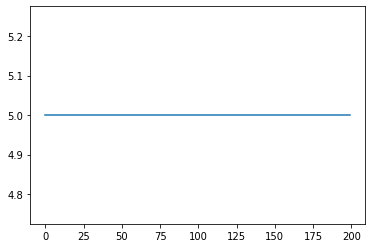

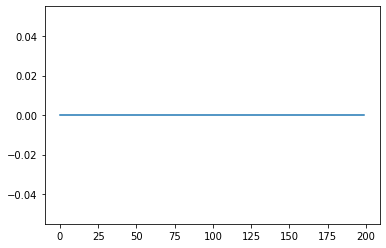

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/39x4.txt
WORKING ON IT ...
Number of satisfied eq is:  5
Fitness:  0
Solution x:  [2.05499926 2.12608227 5.58342652 4.2750343 ]


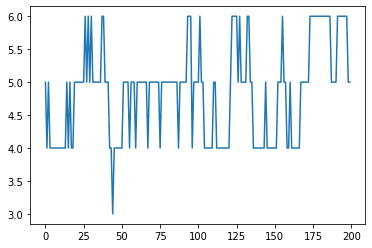

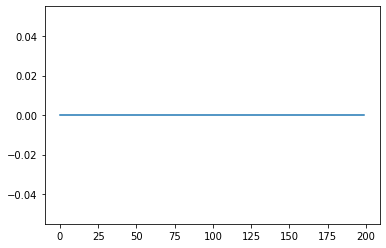

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/38x4.txt
WORKING ON IT ...
Number of satisfied eq is:  4
Fitness:  0
Solution x:  [1.25724765 1.71865413 2.67807078 2.41012262]


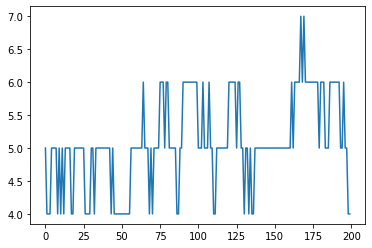

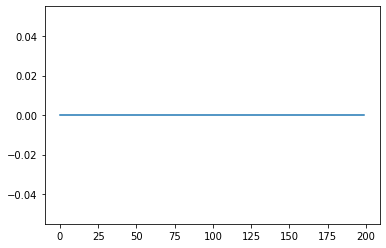

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/50x11.txt
WORKING ON IT ...
Number of satisfied eq is:  10
Fitness:  0
Solution x:  [4.96067783 1.72876992 1.31499931 5.85557834 6.26063761 0.
 1.42138221 2.27612254 3.39137346 1.44342511 0.90014078]


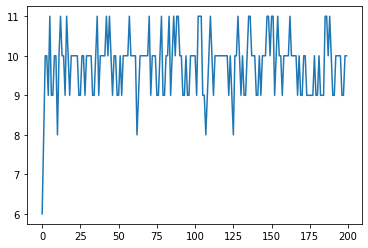

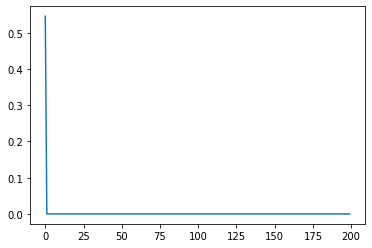

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/8x30.txt
WORKING ON IT ...
Number of satisfied eq is:  8
Fitness:  0
Solution x:  [0.         0.         0.         0.         0.         0.
 0.2288906  0.16101761 0.         0.48065317 0.         0.
 0.         0.68292374 0.         0.         0.         0.
 0.         0.         0.37416505 0.         0.         0.39959476
 0.         1.21300874 0.         0.         0.         0.51373454]


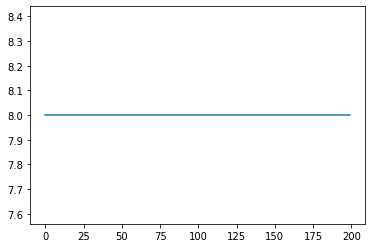

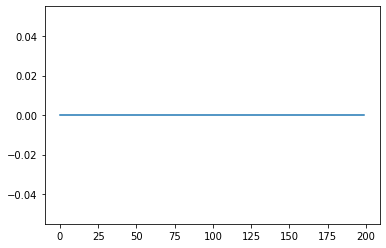

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/5x20.txt
WORKING ON IT ...
Number of satisfied eq is:  5
Fitness:  0
Solution x:  [0.         0.         0.         2.6859125  0.         0.64035939
 0.         0.         0.05355311 0.         0.         0.
 0.         0.         0.         2.11567862 0.         0.30292109
 0.         0.        ]


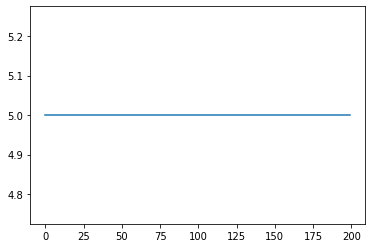

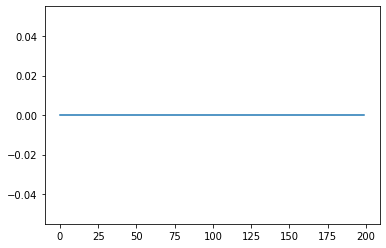

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/simple_test1.txt
WORKING ON IT ...
Number of satisfied eq is:  2
Fitness:  0
Solution x:  [0.22727273 0.         0.00226244]


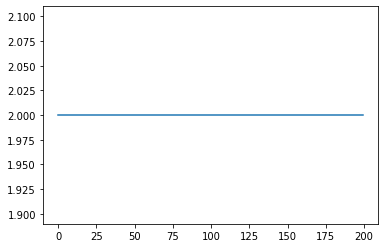

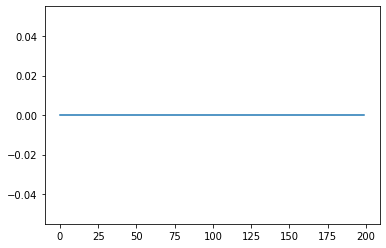

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/simple_test0.txt
WORKING ON IT ...
Number of satisfied eq is:  16
Fitness:  0
Solution x:  [0.         0.22727273 4.58677686]


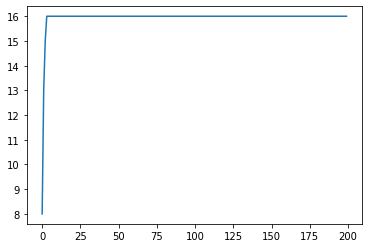

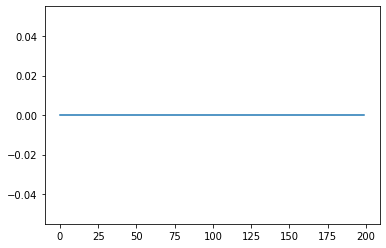

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/simple_test2.txt
WORKING ON IT ...
Number of satisfied eq is:  5
Fitness:  0
Solution x:  [0.22727273 0.         0.00226244]


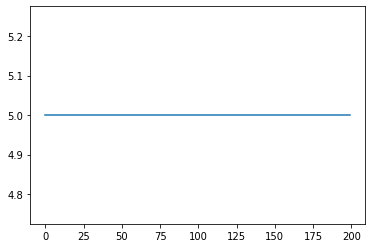

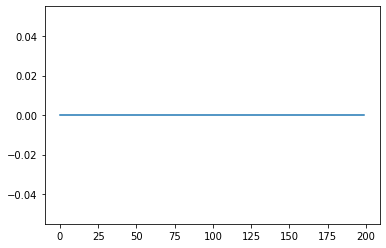

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  tests/35x4.txt
WORKING ON IT ...
Number of satisfied eq is:  4
Fitness:  0
Solution x:  [0.76398017 2.77972222 0.74177097 0.07246533]


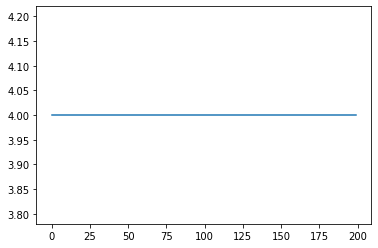

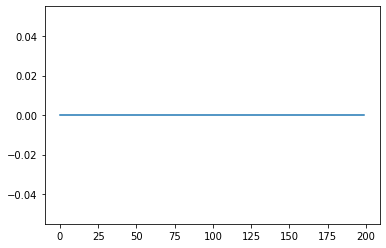

-----------------------------------------------------------------


In [33]:
fileNames = getFiles('tests')
for fileName in fileNames:
    ga(100, iters, 10, 0.06, True, 5, fileName)

# Big tests

In [34]:
iters = 200

-----------------------------------------------------------------
FILE:  bigTests/99x10.txt
WORKING ON IT ...
Number of satisfied eq is: 1


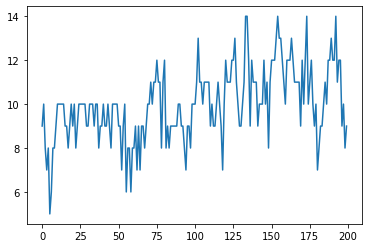

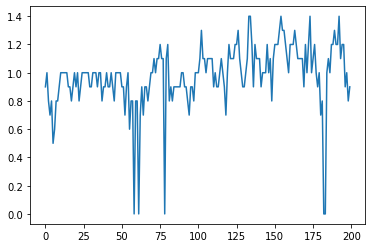

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  bigTests/200x5.txt
WORKING ON IT ...
Number of satisfied eq is:  3
Fitness:  0
Solution x:  [1.00810258 0.34457973 0.32955573]


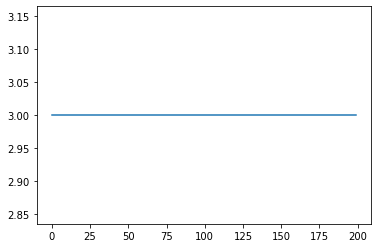

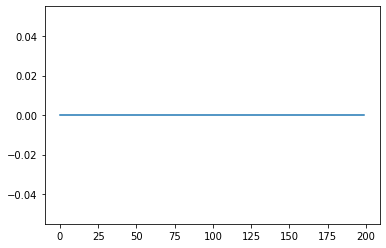

-----------------------------------------------------------------
-----------------------------------------------------------------
FILE:  bigTests/100x50.txt
WORKING ON IT ...


In [ ]:
fileNames = getFiles('bigTests')
for fileName in fileNames:
    ga(100, iters, 10, 0.06, True, 5, fileName)